# Summary of Fraud Detection Code Lab
### - Data is highly imbalanced
### - Features of interval_after_signup and time related raw and aggregates are highly predictive of fraud. 
### - Made actionable operation recommendations/proposal for business. Create a scorecard to quantify the index of fraud probability.
   recommended:
   <ul>
            <li>green: 1 - 3 pass</li>
            <li>grey: 4-7 need manual investigation</li>
            <li>red: 8,9 decline</li>
   </ul>
### - After dive deep into the miss classification cases, I don't see significant feature to differentiate between fraud or non fraud. 
   recommended:
       <ul>
         <li>Add more sign up or purchase information such as sign up ip_Address to compare with the purchase ip_address.</li>
         <li>Add two-way authentication to verify the purchase identity.</li>
       </ul>

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read DataSets

In [5]:
# Ready Data Set
data = pd.read_csv('imbalancedFraudDF.csv')
ipAddress = pd.read_csv('IpAddress_to_Country.csv')
data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0


# Exploratory data analysis

In [6]:
import pandas_profiling

In [7]:
# Explore dataset using Profiling. It provides a brief summary of each variable. 
# Such as variable type, missing percent, distinct, etc.
pandas_profiling.ProfileReport(data)

C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,11
Number of observations,138376
Total Missing (%),0.0%
Total size in memory,11.6 MiB
Average record size in memory,88.0 B
Numeric,4
Categorical,5
Boolean,1
Date,0
Text (Unique),1
Rejected,0


In [31]:
import time

In [32]:
# Create "Country" Column by ip_address, find where each transaction happened. 
# The run time is more than 9 mins by pseudo coding. An improving would be using Binary Search
start = time.time()
countries = []
for i in range(len(data['ip_address'])):
    ip_address = data.loc[i, 'ip_address']
    temp = ipAddress[(ipAddress['lower_bound_ip_address'] <= ip_address) & 
                    ((ipAddress['upper_bound_ip_address'] >= ip_address))]
    if len(temp) != 0:
        country = temp['country'].values[0]    
        countries.append(country)
    else:
        countries.append('NA')
data['country'] = countries

end = time.time() - start
print(end) 

549.4465413093567


In [21]:
# We can see the dataset is highly imbalanced, Fraud is about 1% to Non_Fraud cases
data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [312]:
# Split dataset into Fraud and Non-Fraud ones
fraud = data[data['class'] == 1]
non_fraud = data[data['class'] == 0]

In [313]:
fraud.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_after_sign,day_of_time
136961,338149,2015-08-06 22:15:13,2015-09-14 10:41:05,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3.432126e+09,1,United States,3327952.0,Morning
136962,336975,2015-01-12 01:10:07,2015-01-12 01:10:08,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3.905319e+09,1,NA,1.0,Late Night
136963,159902,2015-02-18 11:18:43,2015-05-17 21:33:13,63,ABUBCQDATQMQH,Ads,FireFox,F,46,5.505670e+08,1,United States,7640070.0,Evening


In [316]:
# Find top 5 countries that has fraud cases
fraud['country'].value_counts()[: 5]

United States     525
NA                208
China             115
Japan              73
United Kingdom     41
Name: country, dtype: int64

<AxesSubplot:xlabel='age'>

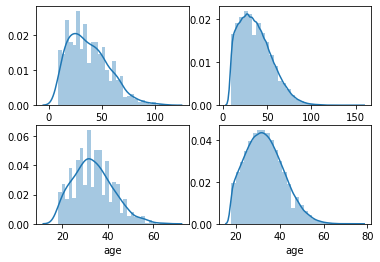

In [27]:
# Looking at the distribution of age and purchase_value. There is no big difference between them.
fig, ax = plt.subplots(2,2)
sns.distplot(fraud['purchase_value'], bins = 30, ax = ax[0,0])
sns.distplot(non_fraud['purchase_value'], bins = 30, ax = ax[0,1])

sns.distplot(fraud['age'], bins = 30, ax = ax[1,0])
sns.distplot(non_fraud['age'], bins = 30, ax = ax[1,1])


In [44]:
from datetime import datetime
# convert "purchase_time" and "signup_time" to datetime format
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['signup_time'] = pd.to_datetime(data['signup_time'])
# Create the time difference by seconds between signup and first purchase
data['purchase_after_sign'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()

In [45]:
# Create time of the day to check if the Fraud happens more offen in certain time than others.
# --> Morning = 0400-1000
mornStart = datetime.strptime('05:00:01', '%H:%M:%S').time()
mornEnd = datetime.strptime('11:00:00', '%H:%M:%S').time()
# --> Midday = 1000-1600
midStart = datetime.strptime('11:00:01', '%H:%M:%S').time()
midEnd = datetime.strptime('17:00:00', '%H:%M:%S').time()

# --> Evening = 1600-2200
eveStart = datetime.strptime('17:00:01', '%H:%M:%S').time()
eveEnd = datetime.strptime('23:00:00', '%H:%M:%S').time()

# --> Late Night = 2200-0400
lateStart = datetime.strptime('23:00:01', '%H:%M:%S').time()
lateEnd = datetime.strptime('05:00:00', '%H:%M:%S').time()

In [51]:
def day_of_time(time):
#    time_cat = []
    if mornStart <= time < mornEnd:
        return 'Morning'
    elif midStart <= time < midEnd:
        return 'Midday'
    elif eveStart <= time < eveEnd:
        return 'Evening'
    else:
        return 'Late Night'

In [60]:
# Create time of day column
data['day_of_time'] = data['purchase_time'].dt.time.apply(day_of_time)
data_new = data.drop(['signup_time','purchase_time','ip_address'], axis = 1)
data_new.head(3)

,user_id,purchase_value,device_id,source,browser,sex,age,class,country,purchase_after_sign,day_of_time
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,Japan,4506682.0,Late Night
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,United States,17944.0,Late Night
2,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,NA,492085.0,Midday


In [61]:
# Unfortunately it doesn't show much difference, Fraud could happen anytime of the day
data_new[data_new['class']==1]['day_of_time'].value_counts()

Midday        378
Morning       373
Late Night    359
Evening       305
Name: day_of_time, dtype: int64

In [121]:
# I create new columns about the frequency of accounts each device shared
# Intuitively the more accounts a device shares, the more likely it might be a fraud
data_new['n_device_shared'] = data_new['device_id'].map(data_new['device_id'].value_counts(dropna = False))

# new column about the frequency of accounts each ip address shared
data_new['n_ipAddress_shared'] = data['ip_address'].map(data['ip_address'].value_counts(dropna = False))

# new column about the frequency of accounts each country happens
data_new['n_country_shared'] = data_new['country'].map(data_new['country'].value_counts(dropna = False))


In [128]:
# Drop 'user_id', 'device_id', 'country'
data_ready = data_new.drop(['user_id', 'device_id', 'country'], axis = 1)
data_ready.head()

,purchase_value,source,browser,sex,age,class,purchase_after_sign,day_of_time,n_device_shared,n_ipAddress_shared,n_country_shared
0,34,SEO,Chrome,M,39,0,4506682.0,Late Night,1,1,6664
1,16,Ads,Chrome,F,53,0,17944.0,Late Night,1,1,53023
2,44,SEO,Safari,M,41,0,492085.0,Midday,1,1,20291
3,39,Ads,Safari,M,45,0,4361461.0,Evening,1,1,53023
4,42,Ads,Chrome,M,18,0,4240931.0,Morning,1,1,2661


# OneHotEncoder

In [126]:
# Use OneHotEncoder to create dummy variables for catogerical variable
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')

In [135]:
drop_enc = pd.DataFrame(encoder.fit_transform(data_new[['source','sex', 'day_of_time', 'browser']]).toarray())
drop_enc.columns = encoder.get_feature_names(['source','sex', 'day_of_time', 'browser'])
data_ready = data_ready.join(drop_enc)
data_ready = data_ready.drop(['source', 'browser', 'sex', 'day_of_time'], axis = 1)
data_ready.head(3)

,purchase_value,age,class,purchase_after_sign,n_device_shared,n_ipAddress_shared,n_country_shared,source_Direct,source_SEO,sex_M,day_of_time_Late Night,day_of_time_Midday,day_of_time_Morning,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,34,39,0,4506682.0,1,1,6664,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16,53,0,17944.0,1,1,53023,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44,41,0,492085.0,1,1,20291,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [136]:
# Create X and y for model selection
X = data_ready.drop(['class'], axis = 1)
y = data_ready['class']

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33)

# Build Model

## Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [164]:
# Train Random Forest Model
rf = RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)

C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<AxesSubplot:>

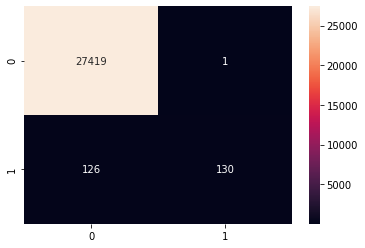

In [147]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_rf, annot = True, fmt='d')

In [148]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27420
           1       0.99      0.51      0.67       256

    accuracy                           1.00     27676
   macro avg       0.99      0.75      0.83     27676
weighted avg       1.00      1.00      0.99     27676



Text(0.5, 1.0, 'Visualizing Important Features')

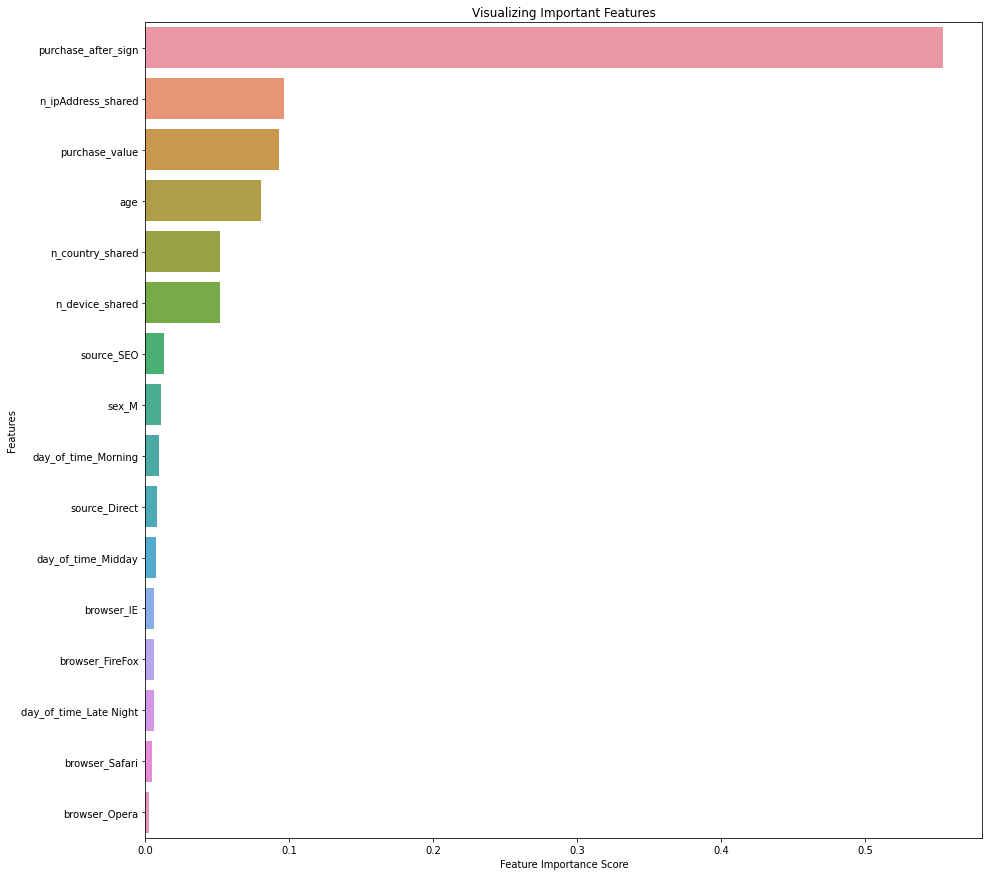

In [155]:
feature_imp = pd.Series(model_rf.feature_importances_,index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

## Decision Tree

In [152]:
dt = DecisionTreeClassifier()
model_dt = dt.fit(X_train, y_train)
dt_pred = model_dt.predict(X_test)

<AxesSubplot:>

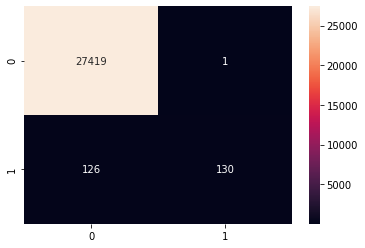

In [153]:
cm_dt = confusion_matrix(y_test, dt_pred)
sns.heatmap(cm, annot = True, fmt = 'd')

In [285]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     27420
           1       0.42      0.51      0.46       256

    accuracy                           0.99     27676
   macro avg       0.71      0.75      0.73     27676
weighted avg       0.99      0.99      0.99     27676



## AdaBoost

In [156]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()

# train model
adaboost.fit(X_train, y_train)

# predict the model using 'X_test'
ada_pred = adaboost.predict(X_test)

<AxesSubplot:>

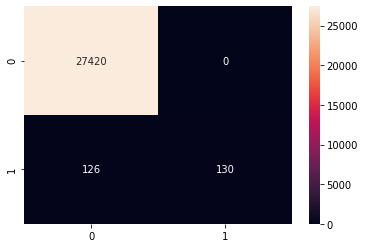

In [157]:
cm_ada = confusion_matrix(y_test, ada_pred)

# plot a heatmap
sns.heatmap(cm_ada, annot=True,fmt='d')

In [158]:
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27420
           1       1.00      0.51      0.67       256

    accuracy                           1.00     27676
   macro avg       1.00      0.75      0.84     27676
weighted avg       1.00      1.00      0.99     27676



## XGboost

In [159]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
model_xgb = xgboost.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_test)

<AxesSubplot:>

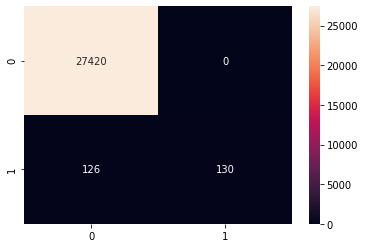

In [161]:
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot = True, fmt = 'd')

## GridSearch

In [199]:
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_score

In [184]:
from sklearn.model_selection import GridSearchCV

In [200]:
# Eval metrics to be calculated for each combination of parameters and cv, they are all calculated(by scoring), but not necessarily used to pick the optimal(by refit)
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)   
}

In [201]:
# Create GridSearch function
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True， n_jobs = -1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search


In [202]:
rf_param = {
    'max_depth': [10, 20],
    'n_estimators' : [50, 150],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'class_weight' : [{ 0: 1, 1: w} for w in [0.1, 1, 100]]
}
rf = RandomForestClassifier(random_state = 33)

In [203]:
grid_search_rf_f1 = grid_search_wrapper(rf, rf_param, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.1}, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27420       0
true_1     126     130
	roc_auc_score is: : 0.8318501834883296
	f1_score is: : 0.6735751295336787
recall =  0.5078125
precision =  1.0


In [204]:
best_RF_model_recall = grid_search_rf_f1.best_estimator_
best_RF_model_recall

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.1},
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

In [206]:
#Var Importance, make a guess?
pd.DataFrame(best_RF_model_recall.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
purchase_after_sign,0.863190
n_ipAddress_shared,0.049428
n_device_shared,0.028483
purchase_value,0.014325
age,0.013573
n_country_shared,0.010893
day_of_time_Morning,0.003709
day_of_time_Late Night,0.002972
sex_M,0.002543
day_of_time_Midday,0.002455


## GridSearch for XGBoost

In [210]:
xgb_param = {
    'max_depth': [10,20], 
    'eta' : [0.3, 0.6, 1], 
    'sampling_method' : ['uniform', 'gradient_based'],
    'subsample': [0.8, 1],
    'lambda' : [1, 5, 10]
}
xgb = XGBClassifier()

In [211]:
grid_search_xgb_f1 = grid_search_wrapper(xgb, xgb_param, refit_score='f1_score')

Best params for f1_score
{'eta': 0.3, 'lambda': 1, 'max_depth': 20, 'sampling_method': 'uniform', 'subsample': 0.8}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27420       0
true_1     126     130
	roc_auc_score is: : 0.8216972812955871
	f1_score is: : 0.6735751295336787
recall =  0.5078125
precision =  1.0


In [212]:
# should be f1 here
best_XGB_model_recall = grid_search_rf_f1.best_estimator_
best_XGB_model_recall

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.1},
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

In [213]:
#Var Importance, make a guess?
pd.DataFrame(best_XGB_model_recall.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
purchase_after_sign,0.863190
n_ipAddress_shared,0.049428
n_device_shared,0.028483
purchase_value,0.014325
age,0.013573
n_country_shared,0.010893
day_of_time_Morning,0.003709
day_of_time_Late Night,0.002972
sex_M,0.002543
day_of_time_Midday,0.002455


In [214]:
#for task 3, based on the above var importance
trainDF = pd.concat([X_train, y_train], axis=1)
pd.crosstab(trainDF["n_ipAddress_shared"],trainDF["class"])
#the larger n_dev_shared, the higher rate of fraud

class,0,1
n_ipAddress_shared,,
1,109177,556
2,209,225
3,100,211
4,43,118
5,11,41
6,1,5
7,0,3


In [215]:
#for task 3, based on the above var importance
trainDF = pd.concat([X_train, y_train], axis=1)
pd.crosstab(trainDF["n_device_shared"],trainDF["class"])
#the larger n_dev_shared, the higher rate of fraud

class,0,1
n_device_shared,,
1,103748,375
2,5511,391
3,211,213
4,54,119
5,16,53
6,1,5
7,0,3


In [223]:
frauld_index = (10 * best_XGB_model_recall.predict_proba(X_test)[:, 1]).astype(int)
unique, counts = np.unique(frauld_index, return_counts = True)
print(np.asarray((unique, counts)).T)

[[    0 27533]
 [    1    11]
 [    2     2]
 [    8     3]
 [    9   114]
 [   10    13]]


## XGB Grid on Recall

In [225]:
grid_search_xgb_recall = grid_search_wrapper(xgb, xgb_param, refit_score='recall_score')

Best params for recall_score
{'eta': 0.3, 'lambda': 1, 'max_depth': 10, 'sampling_method': 'uniform', 'subsample': 0.8}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27420       0
true_1     126     130
	roc_auc_score is: : 0.8342026947711524
	f1_score is: : 0.6735751295336787
recall =  0.5078125
precision =  1.0


In [228]:
best_XGB_model_recall = grid_search_xgb_recall.best_estimator_
best_XGB_model_recall

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              lambda=1, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=1, seed=None, silent=None, subsample=0.8,
              verbosity=1)

In [229]:
#Var Importance, make a guess?
pd.DataFrame(best_XGB_model_recall.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
n_device_shared,0.283674
purchase_after_sign,0.170288
n_ipAddress_shared,0.044079
sex_M,0.043748
source_SEO,0.043371
day_of_time_Late Night,0.043026
n_country_shared,0.042259
purchase_value,0.041846
day_of_time_Midday,0.041163
day_of_time_Morning,0.039380


In [230]:
frauld_index = (10 * best_XGB_model_recall.predict_proba(X_test)[:, 1]).astype(int)
unique, counts = np.unique(frauld_index, return_counts = True)
print(np.asarray((unique, counts)).T)

[[    0 27511]
 [    1    31]
 [    2     3]
 [    4     1]
 [    9   130]]


<AxesSubplot:>

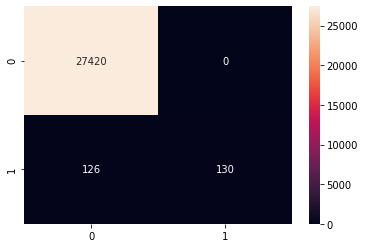

In [232]:
xgb_grid_pred = best_XGB_model_recall.predict(X_test)
cm_xgb_grid = confusion_matrix(y_test, xgb_grid_pred)
sns.heatmap(cm_xgb_grid, annot = True, fmt = 'd')

## CatBoost

In [233]:
from catboost import CatBoostClassifier

In [234]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 33
         }
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.101348
0:	test: 0.7544127	best: 0.7544127 (0)	total: 116ms	remaining: 1m 55s
200:	test: 0.8223631	best: 0.8308311 (2)	total: 9.26s	remaining: 36.8s
400:	test: 0.8238311	best: 0.8308311 (2)	total: 18.8s	remaining: 28.1s
600:	test: 0.8209935	best: 0.8308311 (2)	total: 27.3s	remaining: 18.1s
800:	test: 0.8078666	best: 0.8308311 (2)	total: 36.1s	remaining: 8.97s
999:	test: 0.8050787	best: 0.8308311 (2)	total: 45.3s	remaining: 0us

bestTest = 0.8308310967
bestIteration = 2

Shrink model to first 3 iterations.


In [235]:
feature_importance_cbc = cbc_2.get_feature_importance(prettified=True)
feature_importance_cbc

,Feature Id,Importances
0,n_ipAddress_shared,37.517352
1,purchase_after_sign,33.143614
2,n_device_shared,27.449985
3,purchase_value,1.042692
4,sex_M,0.587005
5,age,0.182305
6,browser_Opera,0.077047
7,n_country_shared,0.000000
8,source_Direct,0.000000
9,source_SEO,0.000000


<AxesSubplot:>

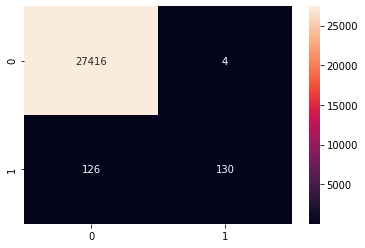

In [240]:
y_pred_cbc = cbc_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_cbc)
sns.heatmap(cm, annot = True, fmt = 'd')

## Grid Search CatBoost

In [297]:
catboost_param = {
    'loss_function':['Logloss'],
    'eval_metric':['AUC'],
    'learning_rate': [0.03, 0.1],
    'depth': [6, 16, 20],
    'l2_leaf_reg': [5, 9],
    'verbose': [200],
    'random_seed': [33]
}
cbc = CatBoostClassifier()

In [298]:
start = time.time()
grid_search_cat = grid_search_wrapper(cbc, catboost_param, refit_score='recall_score')
end = time.time() - end

0:	total: 65.6ms	remaining: 1m 5s
200:	total: 9.71s	remaining: 38.6s
400:	total: 17.7s	remaining: 26.4s
600:	total: 25.9s	remaining: 17.2s
800:	total: 33.6s	remaining: 8.34s
999:	total: 41.9s	remaining: 0us
0:	total: 48.7ms	remaining: 48.7s
200:	total: 9.22s	remaining: 36.7s
400:	total: 20s	remaining: 29.9s
600:	total: 27.6s	remaining: 18.3s
800:	total: 35.3s	remaining: 8.77s
999:	total: 42.6s	remaining: 0us
0:	total: 39.4ms	remaining: 39.3s
200:	total: 7.99s	remaining: 31.7s
400:	total: 16.5s	remaining: 24.7s
600:	total: 25.2s	remaining: 16.7s
800:	total: 33.5s	remaining: 8.32s
999:	total: 41.5s	remaining: 0us
0:	total: 45.5ms	remaining: 45.4s
200:	total: 8.28s	remaining: 32.9s
400:	total: 16.3s	remaining: 24.3s
600:	total: 24s	remaining: 16s
800:	total: 31.4s	remaining: 7.8s
999:	total: 39s	remaining: 0us
0:	total: 38.7ms	remaining: 38.6s
200:	total: 7.86s	remaining: 31.2s
400:	total: 15.5s	remaining: 23.2s
600:	total: 23.7s	remaining: 15.7s
800:	total: 31.5s	remaining: 7.83s
999:	to

KeyboardInterrupt: 

In [299]:
best_cat_model_recall = grid_search_cat.best_estimator_
best_cat_model_recall

In [300]:
# Time after purchase turns out to be the most important feature. 
feature_importance_cbc = best_cat_model_recall.get_feature_importance(prettified=True)
feature_importance_cbc

,Feature Id,Importances
0,purchase_after_sign,20.850560
1,purchase_value,15.179432
2,age,11.755483
3,n_country_shared,11.265028
4,n_device_shared,11.029524
5,n_ipAddress_shared,5.226250
6,browser_Safari,3.786235
7,sex_M,3.430766
8,source_SEO,2.939376
9,day_of_time_Midday,2.873691


<AxesSubplot:>

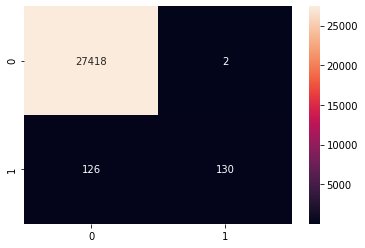

In [301]:
y_pred_cbc = best_cat_model_recall.predict(X_test)
cm = confusion_matrix(y_test, y_pred_cbc)
sns.heatmap(cm, annot = True, fmt = 'd')

In [302]:
frauld_index = (10 * best_cat_model_recall.predict_proba(X_test)[:, 1]).astype(int)
unique, counts = np.unique(frauld_index, return_counts = True)
print(np.asarray((unique, counts)).T)

[[    0 27523]
 [    1    15]
 [    2     3]
 [    3     1]
 [    4     2]
 [    5     1]
 [    6     1]
 [    9   130]]


In [ ]:
#recommended:
#green: 1 - 3 pass
#grey: 4-7 need manual investigation
#red: 8,9 decline

In [303]:
print(classification_report(y_test, y_pred_cbc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27420
           1       0.98      0.51      0.67       256

    accuracy                           1.00     27676
   macro avg       0.99      0.75      0.83     27676
weighted avg       1.00      1.00      0.99     27676



# Dive Deep in model results

In [256]:
# The median of the fraud transaction is only 1 second.
# It means that it's probably a robot action so we can deny this transaction immediately
data_ready.groupby('class')['purchase_after_sign'].median()

class
0    5194911.0
1          1.0
Name: purchase_after_sign, dtype: float64

In [264]:
# Check out the cases that the model miss-classificated
X_combined = pd.concat([X_test, y_test], axis = 1)
# Added back the y_test, y_predict and create "Checked" column to find the miss-classificated cases
X_combined['Predict'] = y_pred_cbc
X_combined.head(3)

,purchase_value,age,purchase_after_sign,n_device_shared,n_ipAddress_shared,n_country_shared,source_Direct,source_SEO,sex_M,day_of_time_Late Night,day_of_time_Midday,day_of_time_Morning,browser_FireFox,browser_IE,browser_Opera,browser_Safari,class,Predict
5109,29,27,1597837.0,1,1,11110,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0
76335,28,40,8249237.0,1,1,6664,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
36395,38,58,6099138.0,1,1,53023,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [269]:
X_combined['Checked'] = pd.Series(X_combined['class'] == X_combined['Predict'])
miss_classified = X_combined[X_combined['Checked'] == False]
miss_classified.head(3)

,purchase_value,age,purchase_after_sign,n_device_shared,n_ipAddress_shared,n_country_shared,source_Direct,source_SEO,sex_M,day_of_time_Late Night,day_of_time_Midday,day_of_time_Morning,browser_FireFox,browser_IE,browser_Opera,browser_Safari,class,Predict,Checked
137582,41,23,2657135.0,1,1,20291,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,False
137839,15,24,9314647.0,1,1,20291,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,False
137286,20,27,9561660.0,1,1,53023,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,False


<AxesSubplot:>

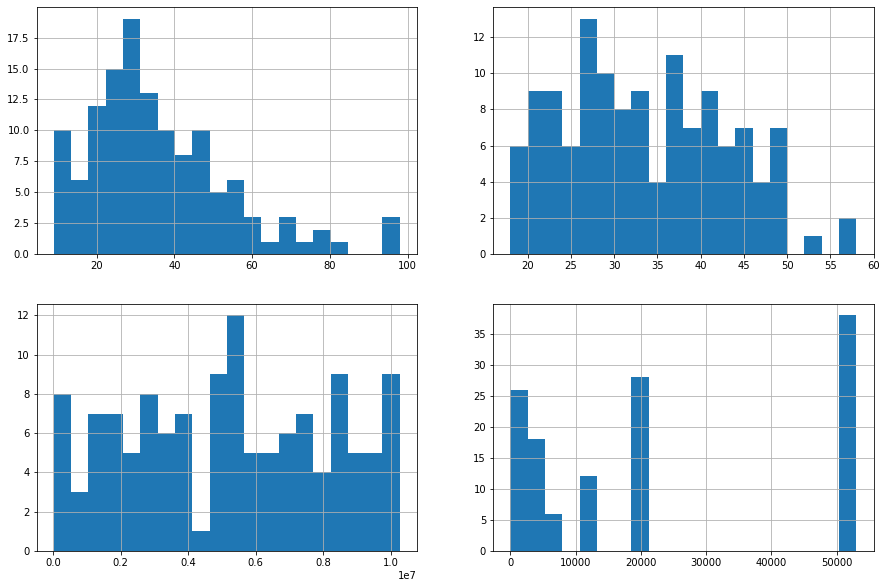

In [308]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
miss_classified['purchase_value'].hist(bins = 20, ax = ax[0,0])
miss_classified['age'].hist(bins = 20, ax = ax[0,1])
miss_classified['purchase_after_sign'].hist(bins = 20, ax = ax[1,0])
miss_classified['n_country_shared'].hist(bins = 20, ax = ax[1,1])